In [32]:
import pandas as pd
import numpy as np
import seaborn as sns

In [33]:
# load datasets
master_table = pd.read_csv("./data/MasterTable.csv")
reference_table = pd.read_csv("./data/HAI-Reference-Table.csv")

print("Reference table shape:", reference_table.shape)
print("Master table shape:", master_table.shape)

Reference table shape: (5113, 54)
Master table shape: (124, 36)


In [34]:
# Extrace HAI as the target variable
reference_table_reduced = reference_table[["tract", "ht_ami"]]
reference_table_reduced["tract"] = reference_table_reduced["tract"].apply(
    lambda x: int(x.replace('"', ""))
)
target_table = reference_table_reduced.rename(
    columns={"tract": "Geo ID", "ht_ami": "HAI"}
)
target_table.head(2)

/tmp/ipykernel_49721/1179816005.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_table_reduced["tract"] = reference_table_reduced["tract"].apply(


,Geo ID,HAI
0,12001000201,36.0
1,12001000202,34.0


In [35]:
# Combine target table with master table
data = pd.merge(master_table, target_table, on="Geo ID", how="inner")
print("Combined data shape:", data.shape)
data.dropna(inplace=True)
print("Data shape after dropping NA:", data.shape)
data.head(2)

Combined data shape: (124, 37)
Data shape after dropping NA: (124, 37)


,Geo ID,Public Transport Commute Rate,Private Vehicle Commute Rate,Walking and Cycling Commute Rate,Other Mobility Commute Rate,Proportion of Home Owners Not Cost Burdened (W),Proportion of Home Renters Not Cost Burdened (W),Proportion of Home Owners Not Cost Burdened (B),Proportion of Home Renters Not Cost Burdened (B),Proportion of Home Owners Not Cost Burdened (H),...,Proportion of Households at Income Level - Low,Proportion of Households at Income Level - Middle,Proportion of Households at Income Level - High,Proportion of Households at Income Level - Very High,Children to Adult Ratio,HUD Subsidization Rate,SNAP Subsidization Rate,Occupancy Rate,Overcrowding Rate,HAI
0,12031000102,0.011542,0.610882,0.000000,0.000000,1.0,0.510638,0.636364,0.134921,0.5,...,0.549876,0.165705,0.178895,0.105523,0.246436,0.108821,27.12,0.795410,0.000000,35.0
1,12031000200,0.039558,0.543698,0.016559,0.054278,1.0,0.000000,0.647059,0.278351,0.0,...,0.514259,0.310028,0.143514,0.032199,0.582962,0.139834,54.74,0.829771,0.019319,33.0


In [36]:
data.corr()["HAI"].abs().sort_values(ascending=False)[1:11]

Proportion of Households at Income Level - Very High    0.819140
SNAP Subsidization Rate                                 0.699534
Education Rate - Bachelor's Degree or Higher            0.690320
Proportion of Households at Income Level - Low          0.676735
HUD Subsidization Rate                                  0.600620
Proportion of Households at Income Level - Middle       0.565981
Education Rate - No High School Diploma                 0.502430
Private Vehicle Commute Rate                            0.488762
Public Transport Commute Rate                           0.376261
Occupancy Rate                                          0.375194
Name: HAI, dtype: float64

## Data Preprocessing

In [37]:
from sklearn.model_selection import train_test_split

# Test Train Split
X = data[data.columns[1:-1]]  # Exclude 'Geo ID' and 'HAI'
y = data["HAI"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (99, 35)
X_test shape: (25, 35)
y_train shape: (99,)
y_test shape: (25,)


## Linear Regression

Linear Regression MSE: 11.213405012233311
Linear Regression R^2: 0.5052676738214161
Proportion of Households at Income Level - Very High              13.839702
Public Transport Commute Rate                                      6.736857
Proportion of Home Renters That Are Cost Burdened (B)              6.495271
Education Rate - Bachelor's Degree or Higher                       6.069102
Proportion of Home Renters That Are Severely Cost Burdened (B)     5.997086
Proportion of Home Owners That Are Cost Burdened (B)               5.981657
Proportion of Home Renters Not Cost Burdened (B)                   5.701299
Private Vehicle Commute Rate                                       5.453798
Children to Adult Ratio                                            4.991827
Education Rate - Some College or Associate's Degree                4.915968
dtype: float64


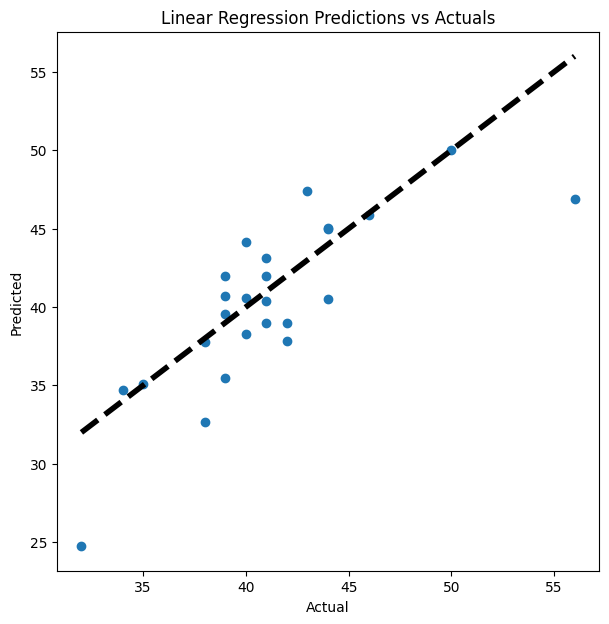

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Linear Regression MSE:", mse)
print("Linear Regression R^2:", r2)

# Feature Importance
feature_importance = pd.Series(
    linear_model.coef_, index=X.columns
).sort_values(ascending=False)
print(feature_importance.head(10))

# Graph Model
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression Predictions vs Actuals')
plt.show()

## Random Forest

Random Forest MSE: 5.16586
Random Forest R^2: 0.7720836862911196
Proportion of Households at Income Level - Very High              0.469755
HUD Subsidization Rate                                            0.095367
SNAP Subsidization Rate                                           0.077406
Proportion of Households at Income Level - Low                    0.073165
Education Rate - Bachelor's Degree or Higher                      0.053901
Private Vehicle Commute Rate                                      0.026454
Proportion of Households at Income Level - Middle                 0.023392
Occupancy Rate                                                    0.021174
Proportion of Home Renters That Are Severely Cost Burdened (W)    0.013231
Proportion of Home Renters That Are Severely Cost Burdened (B)    0.011698
dtype: float64


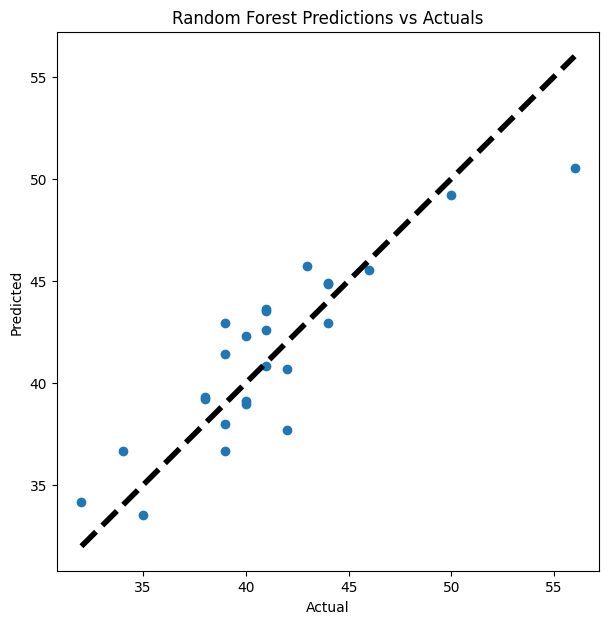

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest MSE:", mse_rf)
print("Random Forest R^2:", r2_rf)

# Feature Importance for Random Forest
feature_importance_rf = pd.Series(
    rf_model.feature_importances_, index=X.columns
).sort_values(ascending=False)
print(feature_importance_rf.head(10))

# Graph Model
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions vs Actuals')
plt.show()

## Neural Network

/home/marion_wsl/Projects/AI4Good_2025/testing/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network MSE: 13.554395855672716
Neural Network R^2: 0.4019838056052909
Proportion of Households at Income Level - Very High              0.156259
Education Rate - Bachelor's Degree or Higher                      0.153008
Proportion of Home Owners That Are Cost Burdened (B)              0.137878
Proportion of Home Owners That Are Severely Cost Burdened (B)     0.135413
Proportion of Home Owners Not Cost Burdened (W)                   0.132740
Proportion of Home Owners That Are Cost Burdened (W)              0.128740
Proportion of Home Owners That Are Severely Cost Burdened (W)     0.127927
Proportion of Home Renters Not Cost Burdened (W)                  0.127557
Proportion of Home Renters That Are Severely Cost Burdened (H)    0.125924
Occupancy Rate                                                    0.123168
dtype: float64


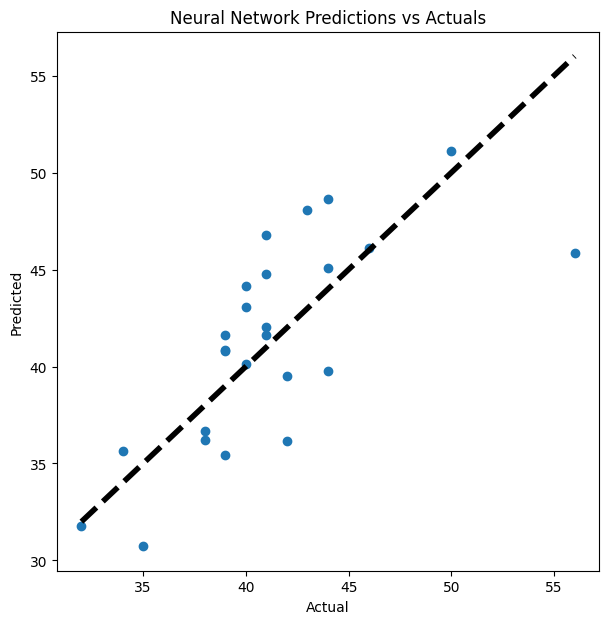

In [40]:
from sklearn.neural_network import MLPRegressor

# Train a Neural Network Regressor
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print("Neural Network MSE:", mse_nn)
print("Neural Network R^2:", r2_nn)

# Feature Importance for Neural Network
feature_importance_nn = pd.Series(
    np.abs(nn_model.coefs_[0]).mean(axis=1), index=X.columns
).sort_values(ascending=False)
print(feature_importance_nn.head(10))

# Graph Model
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_nn)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Neural Network Predictions vs Actuals')
plt.show()

## Aggregation Test

Average Model MSE: 4.78367197532071
Average Model R^2: 0.8771236134971635


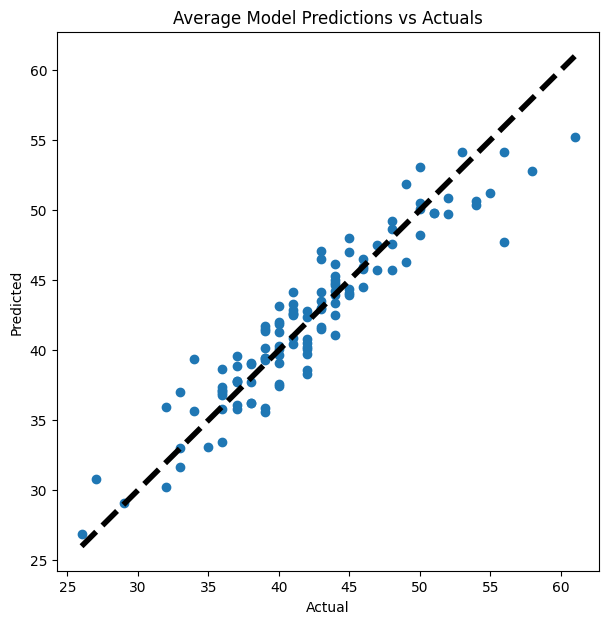

In [41]:
data_sample = data.sample(frac=0.95, random_state=42)

lr = linear_model.predict(data_sample[data_sample.columns[1:-1]])
rf = rf_model.predict(data_sample[data_sample.columns[1:-1]])
nn = nn_model.predict(data_sample[data_sample.columns[1:-1]])

avg_result = (lr + rf + nn) / 3

mse_avg = mean_squared_error(data_sample[data.columns[-1]], avg_result)
r2_avg = r2_score(data_sample[data.columns[-1]], avg_result)
print("Average Model MSE:", mse_avg)
print("Average Model R^2:", r2_avg)

# Graph Average Model Predictions vs Actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(data_sample[data.columns[-1]], avg_result)
plt.plot([data_sample[data.columns[-1]].min(), data_sample[data.columns[-1]].max()],
         [data_sample[data.columns[-1]].min(), data_sample[data.columns[-1]].max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Average Model Predictions vs Actuals')
plt.show()


In [42]:
# Creating HAI Lookup Table
lookup_table = data[["Geo ID"]]
predictions = {
    "linear_hai": linear_model.predict(data[data.columns[1:-1]]).tolist(),
    "forest_hai": rf_model.predict(data[data.columns[1:-1]]).tolist(),
    "nn_hai": nn_model.predict(data[data.columns[1:-1]]).tolist(),
}
predictions["average_hai"] = (
    np.array(predictions["linear_hai"]) +
    np.array(predictions["forest_hai"]) +
    np.array(predictions["nn_hai"])
) / 3
lookup_table = pd.concat([lookup_table, pd.DataFrame(predictions)], axis=1)

# Export lookup table
lookup_table.to_csv("./data/HAI-Lookup-Table.csv", index=False)

lookup_table.head(2)

,Geo ID,linear_hai,forest_hai,nn_hai,average_hai
0,12031000102,35.085135,33.52,30.733191,33.112776
1,12031000200,29.519227,32.11,33.311197,31.646808


In [43]:
# Creating Key Components Dictionary
baseline: int = 30 # 30% rule

weights = pd.Series(linear_model.coef_, index=X_train.columns)
bias = linear_model.intercept_

# per feature partial outputs
partial_outputs = data[["Geo ID"]].copy()
partial_outputs = pd.concat([partial_outputs, data[data.columns[1:-1]].multiply(weights, axis=1)], axis=1)
partial_outputs["bias"] = bias
partial_outputs["linear_hai"] = partial_outputs.drop(columns=["Geo ID"]).sum(axis=1)

# Export partial outputs
partial_outputs.to_csv("./data/HAI-Partial-Outputs.csv", index=False)
# partial_outputs.to_json("./data/HAI-Partial-Outputs.json", orient="records", lines=True)

partial_outputs.head(2)


,Geo ID,Public Transport Commute Rate,Private Vehicle Commute Rate,Walking and Cycling Commute Rate,Other Mobility Commute Rate,Proportion of Home Owners Not Cost Burdened (W),Proportion of Home Renters Not Cost Burdened (W),Proportion of Home Owners Not Cost Burdened (B),Proportion of Home Renters Not Cost Burdened (B),Proportion of Home Owners Not Cost Burdened (H),...,Proportion of Households at Income Level - Middle,Proportion of Households at Income Level - High,Proportion of Households at Income Level - Very High,Children to Adult Ratio,HUD Subsidization Rate,SNAP Subsidization Rate,Occupancy Rate,Overcrowding Rate,bias,linear_hai
0,12031000102,0.077754,3.331627,-0.000000,-0.000000,-6.872102,0.710526,0.818849,0.769225,-0.907412,...,-1.804836,-1.347452,1.460414,1.230165,-3.061951,-2.963604,3.084043,-0.000000,28.205235,35.085135
1,12031000200,0.266499,2.965220,-0.262046,-0.645499,-6.872102,0.000000,0.832611,1.586962,-0.000000,...,-3.376781,-1.080959,0.445621,2.910048,-3.934586,-5.981848,3.217271,-0.456606,28.205235,29.519227
